In [158]:
import quandl as ql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [159]:
import seaborn as sns
sns.set_theme()

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.dummy import DummyClassifier

In [161]:
import joblib

In [162]:
IMAGES_PATH = Path("../images/") 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [163]:
source = Path("../data/data.h5")
dumps = Path("../data/model_dumps/")
dumps.mkdir(parents=True, exist_ok=True)

## Load Data

In [164]:
def load_data(ticker='msft',batch="train"):
    with pd.HDFStore(source) as store:
        data = store['model_data/{}/{}'.format(ticker,batch)]
    return data
    

In [165]:
ticker='msft'

In [166]:
train_set = load_data(ticker, "train")

In [167]:

test_set = load_data(ticker, "test")

In [168]:
train_set.shape

(1445, 30)

In [169]:
test_set.shape

(1698, 30)

## Create Model data

In [170]:
def model_data(data):
    
    OHLCV = ['open', 'close', 'low', 'high', 'volume']
    X = data.drop(OHLCV, axis=1)
    X = X.drop([c for c in data.columns if 'year' in c or 'lag' in c], axis=1)
    y = pd.DataFrame.copy(data.filter(like='target'))
    X = X.drop(y.columns, axis=1)
    y['direction'] = np.sign(y['target_1d']).astype(int)
    
    return X,y

In [171]:
X_train,y_train = model_data(train_set)
X_test, y_test = model_data(test_set)

In [172]:
print("X_train: {}, y_train: {}".format(X_train.shape, y_train.shape))
print("X_test: {}, y_test: {}".format(X_test.shape, y_test.shape))

X_train: (1445, 24), y_train: (1445, 2)
X_test: (1698, 24), y_test: (1698, 2)


In [173]:
horizon = 1 #set prediction horizon

target = 'target_{}d'.format(horizon)

In [174]:
year = 300 # there are roughly 252 trading day in a year
test_period_size = 10
n_splits = 20

In [175]:
tsplit = TimeSeriesSplit(n_splits=n_splits,
                         max_train_size=year,
                         test_size=test_period_size,
                         gap=1)

In [176]:
scores = {}

In [305]:

#for fold, (train_idx, val_idx) in enumerate(tsplit.split(X_train)):
  #  print(fold, train_idx, val_idx)

In [178]:
def param_compare(grid):
    results_df = pd.DataFrame(grid.cv_results_)
    results_df = results_df.sort_values(by=["rank_test_score"])
    results_df = results_df.set_index(results_df["params"]
                                      .apply(lambda x: "_".join(str(val) for val in x.values())))
    return results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

## Model : Dummy classifier

In [294]:
dummy_clf = DummyClassifier(strategy="most_frequent")

In [295]:
dummy_scores = cross_val_score(dummy_clf, X_train, y_train.direction, cv=tsplit, scoring="accuracy")
np.average(dummy_scores)

0.485

In [296]:
dummy_clf.fit(X_train, y_train.direction)

DummyClassifier(strategy='most_frequent')

In [297]:
scores.update({"dummy_clf": dummy_scores})

In [298]:
y_pred_dummy = dummy_clf.predict(X_test)

In [299]:
accuracy_score(y_pred_dummy, y_test.direction)

0.5388692579505301

## Model : Logistic Regression

In [185]:
log_clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [186]:
log_clf_scores = cross_val_score(log_clf, X_train,
                         y_train.direction,cv=tsplit,
                         scoring='accuracy')

In [187]:
np.average(log_clf_scores)

0.45999999999999996

In [188]:
scores.update({'log_clf':log_clf_scores})

In [189]:
log_params = { 'logisticregression__C' : np.logspace(-5,5,11), 
              'logisticregression__solver': ['liblinear', 'saga'], 
              'logisticregression__penalty' : ['l1', 'l2']}

In [190]:
log_grid = GridSearchCV(log_clf, param_grid= log_params, scoring='accuracy', cv=tsplit, n_jobs = -1)

In [191]:
log_grid.fit(X_train, y_train.direction)

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=300, n_splits=20, test_size=10),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [194]:
log_grid.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.001, max_iter=1000, penalty='l1',
                                    solver='saga'))])

In [195]:
y_pred_log = log_grid.best_estimator_.predict(X_test)

In [196]:
log_clf = clone(log_grid.best_estimator_)
log_clf.fit(X_train, y_train.direction)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.001, max_iter=1000, penalty='l1',
                                    solver='saga'))])

In [197]:
y_pred_log = log_clf.predict(X_test)

In [198]:
accuracy_score(y_test.direction, y_pred_log)

0.5388692579505301

In [199]:
(y_test.direction == y_pred_log).value_counts()

True     915
False    783
Name: direction, dtype: int64

In [200]:
joblib.dump(log_grid.best_estimator_, "../data/model_dumps/log_clf_msft.pkl")

['../data/model_dumps/log_clf_msft.pkl']

## Model : Support Vector Machine

In [201]:
from sklearn.svm import SVC,LinearSVC

In [202]:
svm_clf = make_pipeline(StandardScaler(), SVC())

In [203]:
svm_clf_scores = cross_val_score(svm_clf, X_train,
                         y_train.direction,cv=tsplit,
                         scoring='accuracy')

In [204]:
np.average(svm_clf_scores)

0.5

In [205]:
scores.update({'svm_clf': svm_clf_scores})

In [206]:
svc_params = [
  {'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['linear']},
  {'svc__C': [1, 10, 100, 1000], 'svc__gamma': [0.001, 0.0001], 'svc__kernel': ['rbf']},
 ]

In [207]:
svc_grid = GridSearchCV(svm_clf, param_grid=svc_params, scoring='accuracy', cv=tsplit, n_jobs = -1)

In [208]:
svc_grid.fit(X_train, y_train.direction)

GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=300, n_splits=20, test_size=10),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid=[{'svc__C': [1, 10, 100, 1000],
                          'svc__kernel': ['linear']},
                         {'svc__C': [1, 10, 100, 1000],
                          'svc__gamma': [0.001, 0.0001],
                          'svc__kernel': ['rbf']}],
             scoring='accuracy')

In [209]:
y_pred_svm = svc_grid.best_estimator_.predict(X_test)

In [210]:
accuracy_score(y_test.direction, y_pred_svm)

0.5388692579505301

In [211]:
pd.DataFrame(y_pred_svm).value_counts()

1    1698
dtype: int64

In [212]:
joblib.dump(svc_grid.best_estimator_, "../data/model_dumps/svc_clf_msft.pkl")

['../data/model_dumps/svc_clf_msft.pkl']

## Model : Random forest

In [213]:
from sklearn.ensemble import RandomForestClassifier

In [214]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                n_jobs = -1)

In [215]:
rnd_clf_scores = cross_val_score(rnd_clf, X_train, y_train.direction, cv=tsplit, scoring="accuracy")


In [216]:
np.average(rnd_clf_scores)

0.48500000000000004

In [217]:
scores.update({'rnd_clf': rnd_clf_scores})

In [218]:
rf_params = [
    {'n_estimators': [10, 50,100,200], 
     'max_features': [5, 10, 20], 
 'max_depth': [10,20,30], 
     'bootstrap': [True, False]}
]



In [219]:
rf_grid = GridSearchCV(rnd_clf, param_grid=rf_params, scoring='accuracy', cv=tsplit, n_jobs= -1)

In [220]:
rf_grid.fit(X_train,y_train.direction)

GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=300, n_splits=20, test_size=10),
             estimator=RandomForestClassifier(max_leaf_nodes=16,
                                              n_estimators=500, n_jobs=-1),
             n_jobs=-1,
             param_grid=[{'bootstrap': [True, False], 'max_depth': [10, 20, 30],
                          'max_features': [5, 10, 20],
                          'n_estimators': [10, 50, 100, 200]}],
             scoring='accuracy')

In [221]:
y_pred_rf = rf_grid.best_estimator_.predict(X_test)

In [222]:
accuracy_score(y_test.direction, y_pred_rf)

0.535924617196702

In [223]:
for name, score in zip(X_test.columns,rf_grid.best_estimator_.feature_importances_):
    print(name, score)

SMA_5 0.040812156753383726
SMA_21 0.02375249003458298
SMA_63 0.012886324075935578
return_1d 0.08916819144256072
return_5d 0.031080019345723974
return_10d 0.06148957351032301
return_21d 0.028453218318397887
return_42d 0.0409677337917211
return_63d 0.051489783613641114
HT_TRENDLINE 0.02043454677118211
bb_high 0.004940103268763952
bb_low 0.022481791163054994
BB_HIGH 0.03408619276773657
BB_LOW 0.02137187302516281
RSI 0.0416688437782981
MACD 0.035271966851252716
PLUS_DM 0.03652899298105829
MINUS_DM 0.07259526000664415
ADX 0.04881531242805244
PPO 0.04012197070991447
STOCH 0.08369723663676717
MFI 0.0420863900633476
AD 0.02964239434594491
ATR 0.08615763431654962


In [224]:
joblib.dump(rf_grid.best_estimator_, "../data/model_dumps/rf_clf_msft.pkl")

['../data/model_dumps/rf_clf_msft.pkl']

## Model : Neural Network

In [225]:
from sklearn.neural_network import MLPClassifier

In [226]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(50,50,50), max_iter=1000, random_state=42)

In [227]:
neural_clf = make_pipeline(StandardScaler(), mlp_clf)

In [228]:
neural_scores = cross_val_score(neural_clf, X_train, y_train.direction, cv=tsplit, scoring='accuracy')

In [229]:
scores.update({'nn_clf': neural_scores})

In [230]:
neural_scores

array([0.3, 0.4, 0.7, 0.5, 0.6, 0.8, 0.7, 0.3, 0.8, 0.4, 0.6, 0.4, 0.5,
       0.3, 0.6, 0.5, 0.4, 0.2, 0.4, 0.5])

In [231]:
np.average(neural_scores)

0.49499999999999994

In [232]:
neural_params = {
    'mlpclassifier__activation' : ['logistic', 'tanh', 'relu'],
    'mlpclassifier__alpha' : [0.001,0.01,0.1,10],
}

In [233]:
neural_grid = GridSearchCV(neural_clf, param_grid=neural_params, cv=tsplit, scoring='accuracy', n_jobs = -1)

In [234]:
neural_grid.fit(X_train,y_train.direction)

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.wa

GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=300, n_splits=20, test_size=10),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('mlpclassifier',
                                        MLPClassifier(hidden_layer_sizes=(50,
                                                                          50,
                                                                          50),
                                                      max_iter=1000,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'mlpclassifier__activation': ['logistic', 'tanh',
                                                       'relu'],
                         'mlpclassifier__alpha': [0.001, 0.01, 0.1, 10]},
             scoring='accuracy')

In [235]:
neural_grid.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', alpha=0.001,
                               hidden_layer_sizes=(50, 50, 50), max_iter=1000,
                               random_state=42))])

In [236]:
y_pred_nn = neural_grid.best_estimator_.predict(X_test)

In [237]:
accuracy_score(y_test.direction, y_pred_nn)

0.5200235571260307

In [238]:
joblib.dump(neural_grid.best_estimator_, "../data/model_dumps/nn_clf_msft.pkl")

['../data/model_dumps/nn_clf_msft.pkl']

## Ensemble

- voting classifier

In [1]:
from sklearn.ensemble import VotingClassifier

In [5]:
voting_clf = VotingClassifier(estimators=[('lr', clone(log_grid.best_estimator_)),
                                          ('rf', clone(rf_grid.best_estimator_)),
                                         ('sv', clone(svc_grid.best_estimator_)),
                                         ('nn', clone(neural_grid.best_estimator_))],
                             voting='hard')

NameError: name 'log_grid' is not defined

In [3]:
voting_scores = cross_val_score(voting_clf, X_train, y_train.direction, cv=tsplit, scoring='accuracy')

NameError: name 'cross_val_score' is not defined

In [242]:
scores.update({'voting_clf': voting_scores})

In [243]:
voting_clf.fit(X_train, y_train.direction)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression(C=0.001,
                                                                  max_iter=1000,
                                                                  penalty='l1',
                                                                  solver='saga'))])),
                             ('rf',
                              RandomForestClassifier(max_depth=20,
                                                     max_features=20,
                                                     max_leaf_nodes=16,
                                                     n_estimators=10,
                                                     n_jobs=-1)),
                             ('sv',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('svc',
                                               SVC(C=10, gamma=0.001))])),
                             ('nn',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('mlpclassifier',
                                               MLPClassifier(activation='tanh',
                                                             alpha=0.001,
                                                             hidden_layer_sizes=(50,
                                                                                 50,
                                                                                 50),
                                                             max_iter=1000,
                                                             random_state=42))]))])

In [244]:
y_pred_vote = voting_clf.predict(X_test)

In [245]:
accuracy_score(y_test.direction, y_pred_vote)

0.5318021201413428

In [246]:
joblib.dump(voting_clf, "../data/model_dumps/vot_clf_msft.pkl")

['../data/model_dumps/vot_clf_msft.pkl']

### Adaptive Boosting

In [247]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [248]:
ada_clf = AdaBoostClassifier()

In [249]:
ada_scores = cross_val_score(ada_clf, X_train, y_train.direction, scoring='accuracy', cv=tsplit)

In [250]:
scores.update({'adaboost': ada_scores})

In [251]:
np.average(ada_scores)

0.45999999999999996

In [252]:
ada_params = {
    #'estimator__max_depth': [5,10,15,20],
    #'estimator__max_features': [2,5,10,20],
    #'max_leaf_nodes': [2,4,8,16,24],
    'learning_rate': [0.01,0.1,0.2,0.5,1],
    'n_estimators': [10,20,40,100,150,200,500]
}

In [253]:
ada_grid = GridSearchCV(ada_clf,param_grid=ada_params,
                       cv=tsplit, scoring='accuracy', n_jobs=-1)

In [254]:
ada_grid.fit(X_train, y_train.direction)

GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=300, n_splits=20, test_size=10),
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                         'n_estimators': [10, 20, 40, 100, 150, 200, 500]},
             scoring='accuracy')

In [255]:
y_pred_ada = ada_grid.best_estimator_.predict(X_test)

In [256]:
accuracy_score(y_pred_ada, y_test.direction)

0.5129564193168433

In [257]:
joblib.dump(ada_grid.best_estimator_, "../data/model_dumps/ada_clf_msft.pkl")

['../data/model_dumps/ada_clf_msft.pkl']

### Gradient Boosting

In [258]:
from sklearn.ensemble import GradientBoostingClassifier

In [259]:
from xgboost import XGBClassifier

In [260]:
grb_clf = GradientBoostingClassifier()

In [261]:
grb_scores = cross_val_score(grb_clf, X_train,
                             y_train.direction,
                            scoring= 'accuracy',
                            cv=tsplit)

In [262]:
scores.update({'gradboost': grb_scores})

In [263]:
np.average(grb_scores)

0.4699999999999999

In [264]:
grb_params = {
    "max_depth" : [2,4,8,16,20],
    "n_estimators": [1,2,4,8,16,32,64,128,200],
    "learning_rate": [0.01,0.1,1,10],
}

In [265]:
grb_grid = GridSearchCV(grb_clf, param_grid=grb_params,
                       cv=tsplit,
                       scoring="accuracy", n_jobs=-1)

In [266]:
grb_grid.fit(X_train, y_train.direction)

GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=300, n_splits=20, test_size=10),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1, 10],
                         'max_depth': [2, 4, 8, 16, 20],
                         'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128, 200]},
             scoring='accuracy')

In [267]:
y_pred_grb = grb_grid.best_estimator_.predict(X_test)

In [268]:
accuracy_score(y_test.direction, y_pred_grb)

0.47644287396937574

In [269]:
joblib.dump(grb_grid.best_estimator_, "../data/model_dumps/grb_clf_msft.pkl")

['../data/model_dumps/grb_clf_msft.pkl']

## preserve model statistics and final results

In [313]:
lg_clf = log_grid.best_estimator_
sv_clf = svc_grid.best_estimator_
rf_clf = rf_grid.best_estimator_
n_clf = neural_grid.best_estimator_
adaboost = ada_grid.best_estimator_
grbboost = grb_grid.best_estimator_

In [314]:
models = {'log_clf': lg_clf,
          'svm_clf': sv_clf,
          'rnd_clf': rf_clf,
          'mlp_clf': n_clf,
          'vot_clf':voting_clf,
          'ada_clf': adaboost,
          'grb_clf': grbboost,
          'dummy_clf': dummy_clf}

In [315]:
X_test.columns

Index(['SMA_5', 'SMA_21', 'SMA_63', 'return_1d', 'return_5d', 'return_10d',
       'return_21d', 'return_42d', 'return_63d', 'HT_TRENDLINE', 'bb_high',
       'bb_low', 'BB_HIGH', 'BB_LOW', 'RSI', 'MACD', 'PLUS_DM', 'MINUS_DM',
       'ADX', 'PPO', 'STOCH', 'MFI', 'AD', 'ATR'],
      dtype='object')

In [316]:
def save_results(test_set, X_test, models, ticker):
    
    test_results = test_set.loc[X_test.index]
    for model in  models.keys():
        #test_set[model] = model.predict(X_test)
        test_results[model] = test_results['target_1d'] * models[model].predict(X_test)
    test_results.to_hdf(source, 'models/results/{}'.format(ticker))
    return test_results

In [317]:
test_results = save_results(test_set,X_test,models,ticker)

## Comparison of strategies

### 1. comparing returns

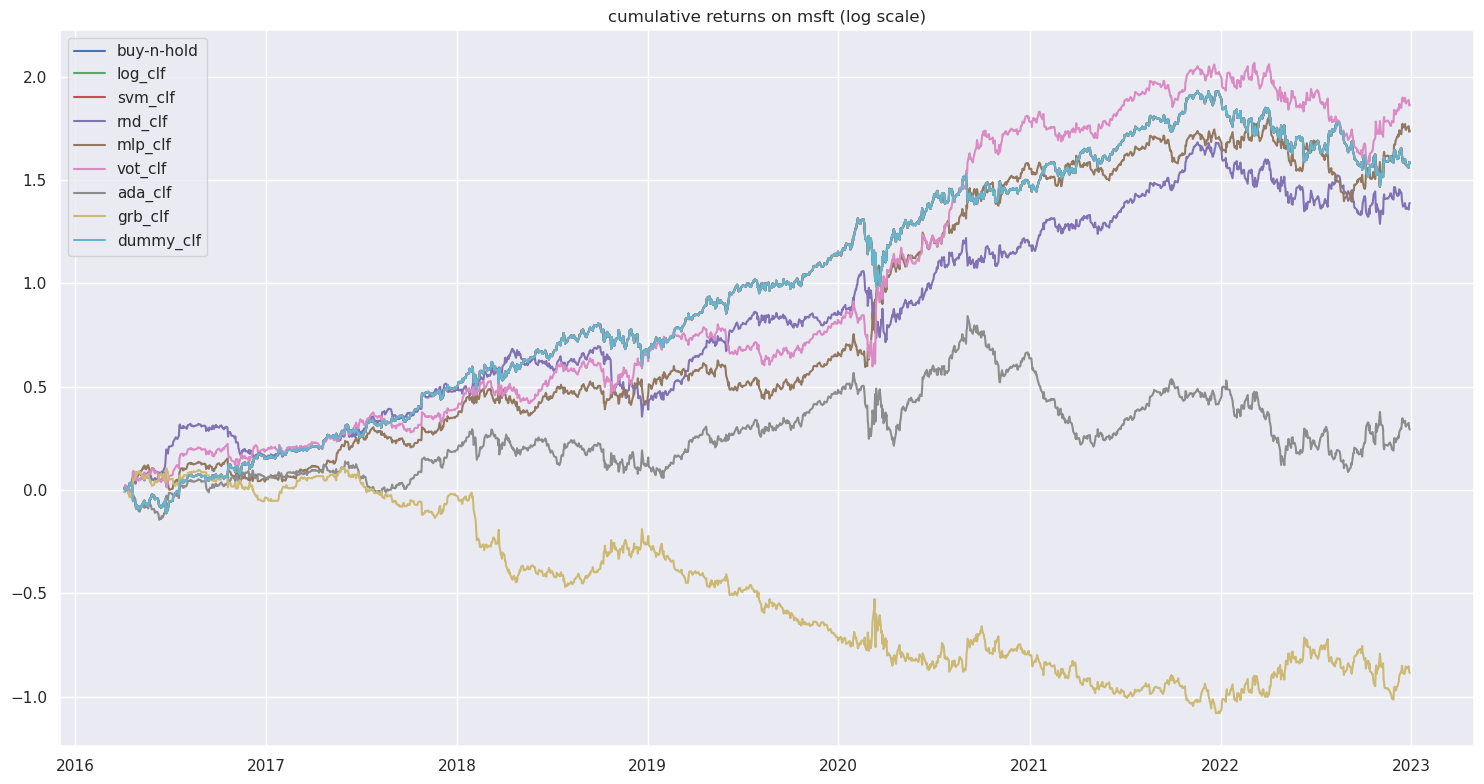

In [318]:
fig,ax = plt.subplots(figsize=(15,8))

plt.plot(test_results[[target]].cumsum(), label='buy-n-hold')
plt.plot(test_results[['svm_clf']].cumsum(), label='')

for model in models.keys():
    plt.plot(test_results[[model]].cumsum(), label = model)
plt.legend()
plt.title('cumulative returns on {} (log scale)'.format(ticker))
save_fig("returns_{}".format(ticker))
plt.show()

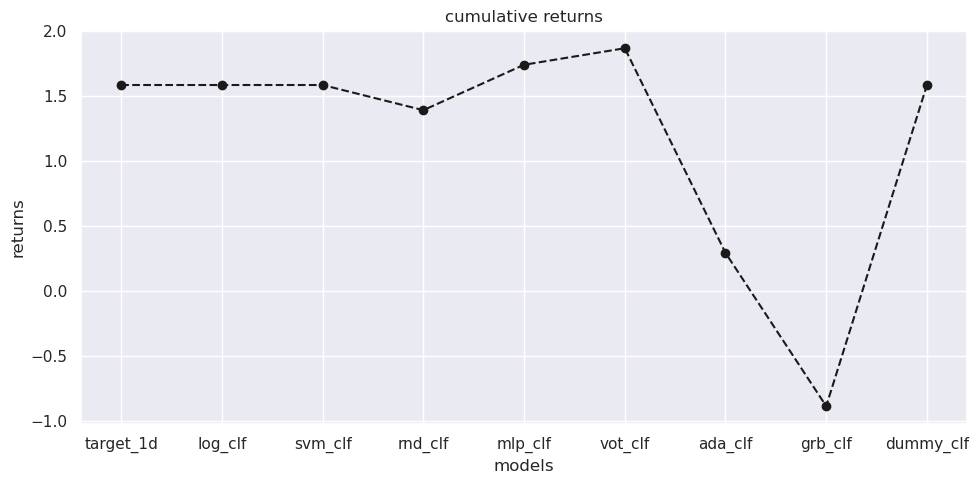

In [319]:
cum_returns = test_results[[target] + list(models.keys())].sum()
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(cum_returns, 'ko--',)
#ax.set_yticks(np.arange(0,.8,0.1))
plt.title("cumulative returns")
plt.xlabel('models')
#plt.yticks(np.arange(-1,3, .3))
plt.ylabel('returns')
save_fig("returns_dist_{}".format(ticker))
plt.show()

### 2. comparing models

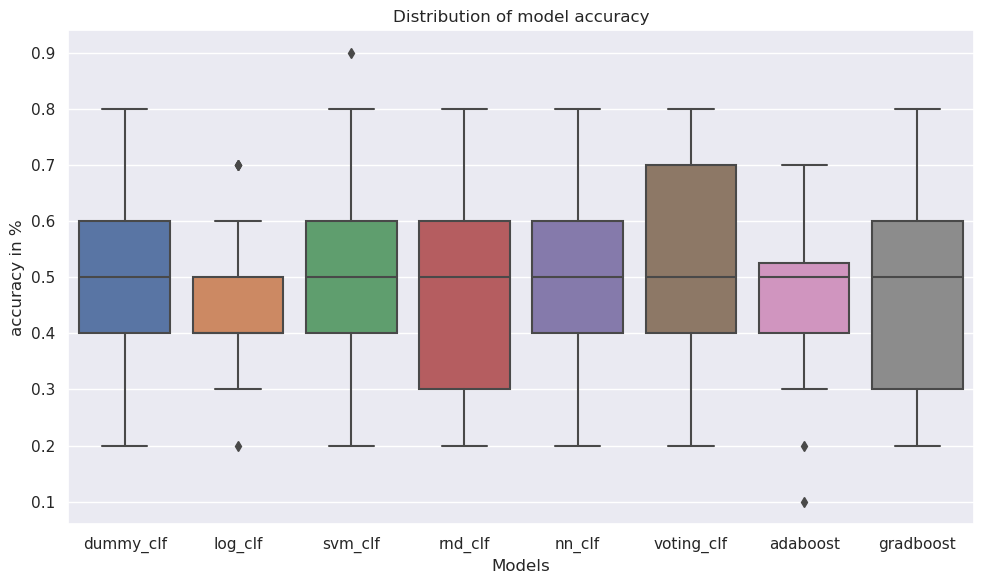

In [320]:
fig,ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=pd.DataFrame(scores), ax = ax)
plt.title('Distribution of model accuracy')
ax.set_xlabel("Models")
ax.set_ylabel("accuracy in %")
#plt.legend()
save_fig("accuracy_valid_{}".format(ticker))
plt.show()

In [321]:
accuracy_test = {}
for model in models.keys():
    accuracy_test.update({model: accuracy_score(y_test.direction,models[model].predict(X_test))})
    

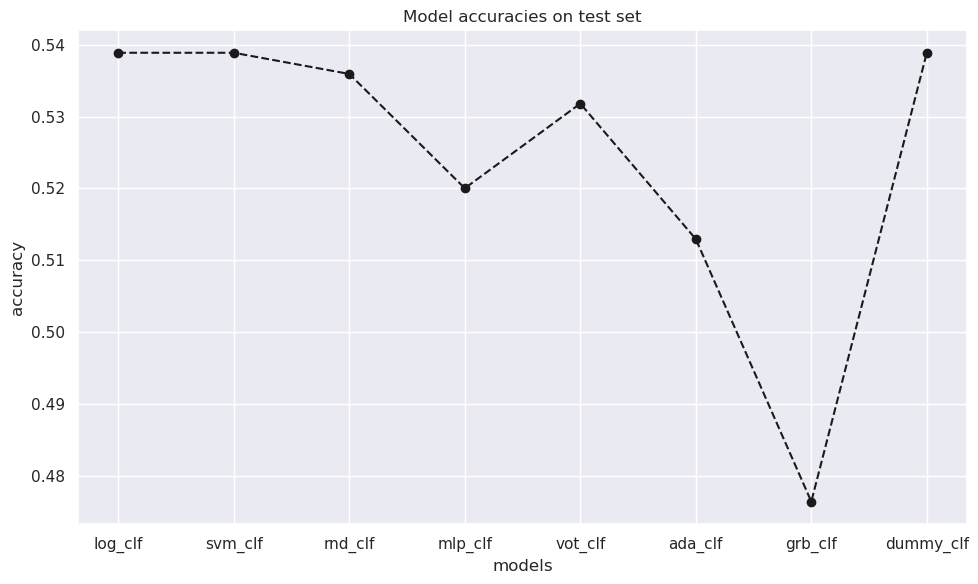

In [322]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(pd.Series(accuracy_test), 'ko--',)
#ax.set_yticks(np.arange(0,.8,0.1))
plt.title("Model accuracies on test set")
plt.xlabel('models')
plt.ylabel('accuracy')
save_fig("accuracy_dist_{}".format(ticker))
plt.show()